In [17]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [18]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [19]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,2.667278,-6.223639,-10.455910,-7.705863,3.942457,5.992100
1,-3.501386,-5.147262,15.075128,7.256400,-0.475929,-2.861587
2,3.822823,-9.720933,-9.241361,-5.683146,6.891798,3.425873
3,3.279096,11.735168,-4.228587,-1.351361,-4.169562,-4.644408
4,-2.105618,-2.101908,0.199927,13.780579,-3.819936,-1.524870


<Axes: >

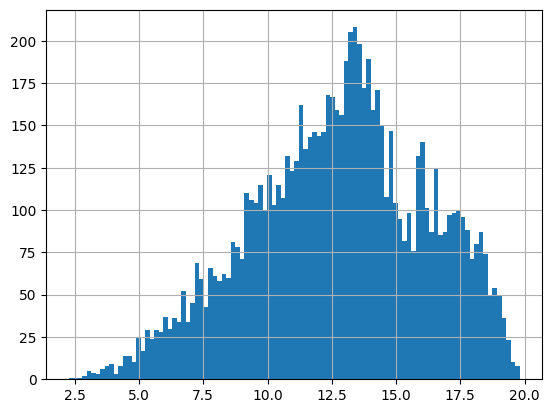

In [20]:
predict.max(axis=1).hist(bins=100)

In [21]:
# softmax
predict = predict.apply(lambda x: np.exp(x-x.max()) / np.exp(x-x.max()).sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [22]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,3.088938e-02,4.251410e-06,6.172787e-08,9.656318e-07,1.105637e-01,8.585417e-01,0.858542,5,Walking,Walking
1,8.553575e-09,1.649503e-09,9.995978e-01,4.019711e-04,1.762329e-07,1.621844e-08,0.999598,2,Sitting,Sitting
2,4.311780e-02,5.658200e-08,9.140159e-08,3.208242e-06,9.278878e-01,2.899103e-02,0.927888,4,Upstairs,Upstairs
3,2.125599e-04,9.997851e-01,1.166638e-07,2.072522e-06,1.237571e-07,7.697457e-08,0.999785,1,Jogging,Jogging
4,1.260989e-07,1.265676e-07,1.264727e-06,9.999982e-01,2.270872e-08,2.253861e-07,0.999998,3,Standing,Standing
5,5.681119e-08,2.745342e-10,1.351457e-10,1.594039e-09,1.670191e-06,9.999983e-01,0.999998,5,Walking,Walking
6,9.994894e-01,1.882594e-08,7.075560e-09,1.113449e-07,5.091837e-04,1.320373e-06,0.999489,0,Downstairs,Downstairs
7,9.920775e-01,3.448274e-08,1.554313e-06,2.307172e-06,1.698901e-03,6.219663e-03,0.992078,0,Downstairs,Downstairs
8,1.318369e-08,9.999999e-01,5.376184e-08,3.254347e-09,3.138519e-10,1.247143e-08,1.000000,1,Jogging,Jogging
9,7.335290e-06,2.056650e-09,4.672415e-10,1.345624e-08,5.923058e-07,9.999921e-01,0.999992,5,Walking,Walking


Accuracy:  0.9520456476872647


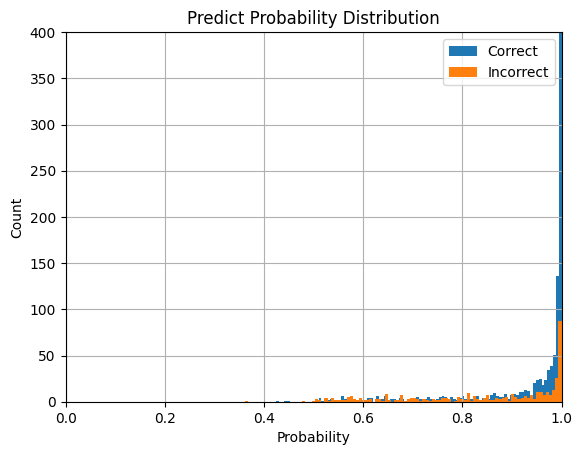

In [23]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [24]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.983978
std       0.065686
min       0.362225
max       1.000000
median    0.999995
Name: predict_probability, dtype: float64

In [25]:
thresholds = [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        # 'confidence_count': len(df_confidence),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    cm_df = pd.DataFrame(cm, index=LABELS[:len(cm)], columns=LABELS[:len(cm)])
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 14},
        square=True,
    )
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_7323/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.952046,1.000000,0.000000,0.000000
0.4,0.952161,0.999879,0.000000,0.000121
0.5,0.952259,0.999393,0.600000,0.000607
0.6,0.957097,0.990409,0.430380,0.009591
0.7,0.961967,0.979968,0.466667,0.020032
0.8,0.966621,0.967464,0.518657,0.032536
0.9,0.973311,0.950710,0.541872,0.049290


# process to gaussian

Before standardization
std: 0.06568553328707862
--- After standardization ---
std: 0.9999999999999999


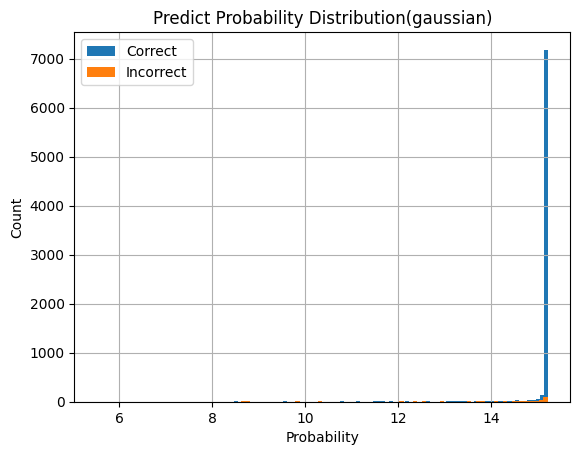

In [26]:
print("Before standardization")
std = df["predict_probability"].std()
print(f"std: {std}")
df["predict_probability_gaussian"] = df["predict_probability"].apply(lambda x: x / std)
print("--- After standardization ---")
std = df["predict_probability_gaussian"].std()
print(f"std: {std}")
df.loc[df.true_label==df.predict_label, 'predict_probability_gaussian'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_gaussian'].hist(bins=100)
plt.title('Predict Probability Distribution(gaussian)')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [27]:
thresholds = [0, 6, 8,  9, 10]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_gaussian'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_7323/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0,0.952046,1.000000,0.000000,0.000000
6,0.952161,0.999879,0.000000,0.000121
8,0.953019,0.997451,0.571429,0.002549
9,0.956522,0.991259,0.444444,0.008741
10,0.959783,0.984096,0.473282,0.015904


# process to torncurve

## 1 - (1 - x) ** 2

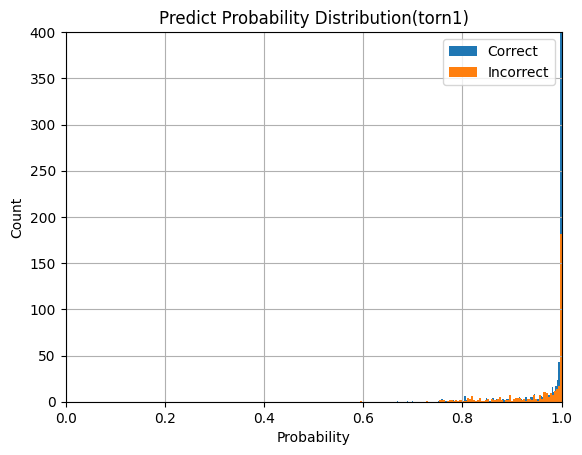

In [28]:
torn1_function = lambda x: 1-(1-x)**2
df["predict_probability_torn1"] = df["predict_probability"].apply(torn1_function)
df.loc[df.true_label==df.predict_label, 'predict_probability_torn1'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_torn1'].hist(bins=100)
plt.title('Predict Probability Distribution(torn1)')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [29]:
thresholds = [0, 0.5, 0.6, 0.7, 0.8]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_torn1'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_7323/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_7323/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.952046,1.000000,0.000000,0.000000
0.5,0.952046,1.000000,0.000000,0.000000
0.6,0.952161,0.999879,0.000000,0.000121
0.7,0.952144,0.999514,0.750000,0.000486
0.8,0.954263,0.995387,0.473684,0.004613


## 1/ln(2) * ln(1+x)

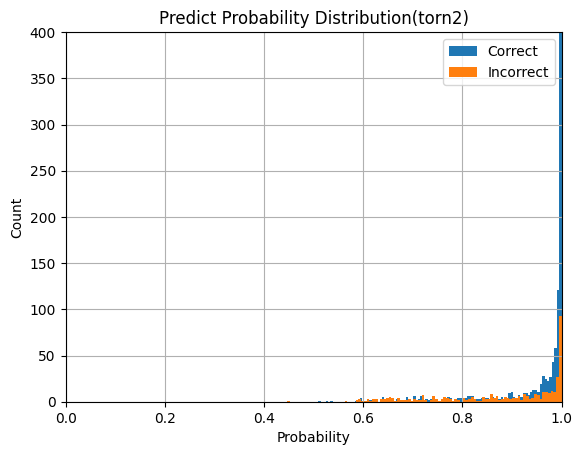

In [30]:
torn2_function = lambda x: (1/np.log(2))*np.log(1+x)
df["predict_probability_torn2"] = df["predict_probability"].apply(torn2_function)
df.loc[df.true_label==df.predict_label, 'predict_probability_torn2'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_torn2'].hist(bins=100)
plt.title('Predict Probability Distribution(torn2)')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [31]:
thresholds = [0, 0.5, 0.55, 0.6, 0.65]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_torn2'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_7323/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.00,0.952046,1.000000,0.000000,0.000000
0.50,0.952161,0.999879,0.000000,0.000121
0.55,0.952144,0.999514,0.750000,0.000486
0.60,0.952914,0.997815,0.555556,0.002185
0.65,0.955257,0.993080,0.491228,0.006920


/home/nakagawaren/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


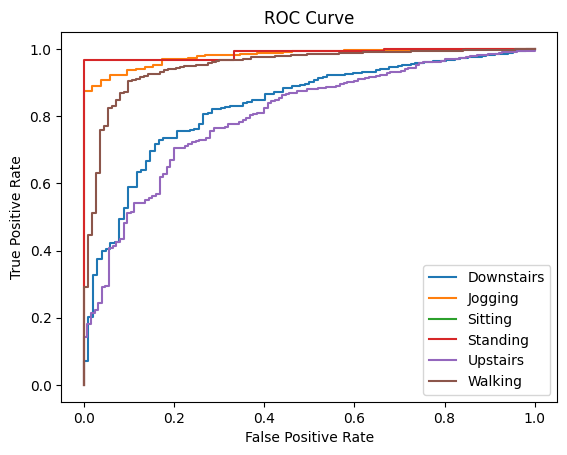

In [32]:
from sklearn.metrics import roc_curve

LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
for label in LABELS:
    fpr, tpr, thresholds = roc_curve(df.loc[df.predict_label==label, 'true_label'], df.loc[df.predict_label==label, "predict_probability"], pos_label=label)
    plt.plot(fpr, tpr, label=label)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()